<a href="https://colab.research.google.com/github/yoontori/prac_class/blob/main/TransferFees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from google.colab import files
uploaded = files.upload()

Saving FIFA_test.csv to FIFA_test (7).csv
Saving FIFA_train.csv to FIFA_train (7).csv
Saving submission2.csv to submission2 (7).csv


In [96]:
import numpy as np 
import pandas as pd 
import io
import matplotlib.pyplot as plt

fifa_train = pd.read_csv(io.StringIO(uploaded['FIFA_train.csv'].decode('utf-8')))
fifa_test = pd.read_csv(io.StringIO(uploaded['FIFA_test.csv'].decode('utf-8')))

In [ ]:
먼저 test 데이터를 불러왔다.

In [86]:
fifa_train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5,94,94,4,110500000
1,3,De Gea,27,europe,2020,GK,right,4,91,93,1,72000000
2,7,L. Suárez,31,south america,2021,ST,right,5,91,91,3,80000000
3,8,Sergio Ramos,32,europe,2020,DF,right,4,91,91,3,51000000
4,9,J. Oblak,25,europe,2021,GK,right,3,90,93,1,68000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1,48,63,3,60000
8928,16936,C. Ehlich,19,europe,2020,DF,right,1,47,59,2,40000
8929,16941,N. Fuentes,18,south america,2021,DF,right,1,47,64,2,50000
8930,16942,J. Milli,18,europe,2021,GK,right,1,47,65,1,50000


train 데이터는 8000명 이상의 선수 정보가 담겨있다. 선수의 나이, 출신대륙, 계약만료연도, 포지션, 사용하는발, 역량 등의 columns가 있다.  

column이 많지 않아서 모든 column을 .unique()를 이용해 어떤 값들이 있는지 확인해보았고 그중 contract_until 중에 만료 월과 일까지 포함된 데이터가 있음을 발견했다. 계약 만료 연도만 남기기 위해 소수점을 이용해 데이터를 표현한 후 반올림하였다. 추후에 연도가 아니라 몇년이 남았는지를 계산하고 사용할 것이기 때문에 데이터 타입을 정수(int)로 바꿔주는 작업도 필요했다. 

In [67]:
fifa_train['contract_until'] = fifa_train['contract_until'].astype(int)

각 변수를 이용해 시각화를 해보며 어떤 패턴이 있는지 알아보았다. 

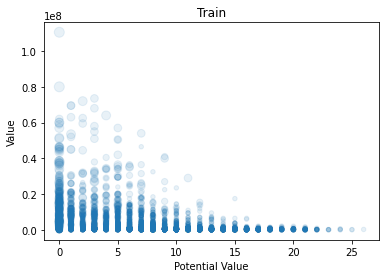

In [103]:
# 잠재 역량에서 기존 역량을 빼 잠재 가치를 산출 
x = fifa_train['stat_potential']-fifa_train['stat_overall']
y = fifa_train['value']
# 인지도에 따라 점의 사이즈를 차등화 
size = fifa_train['reputation']*20

fig = plt.figure() 
ax = fig.add_subplot() 
# for x1,y1 in zip(x,y):
ax.scatter(x,y,color='tab:blue',alpha=0.1,sizes=size)
ax.set_title('Train')
ax.set_xlabel('Potential Value')
ax.set_ylabel('Value')
plt.show()

기존 역량과 잠재 역량을 보고 차이를 구한 다음 이들의 몸값을 시각화하였다. 또 점의 사이즈를 각 선수의 인지도(reputation)에 따라서 크기를 다르게 했다. 

 

이 그래프를 그리기 전까지는 잠재 가치가 높을 수록 몸값이 높지 않을까 싶었는데, 인지도까지 더해서 잠재 가치가 높아도 인지도가 낮으면 몸값이 높게 평가되진 않는 것으로 보였다. 또 잠재가치가 적은 선수들은 이미 역량 점수가 높고 인지도도 높았다. 

몸 값을 높이려면 잠재가치와 인지도를 적절하기 조화해야 한다고 생각했다.

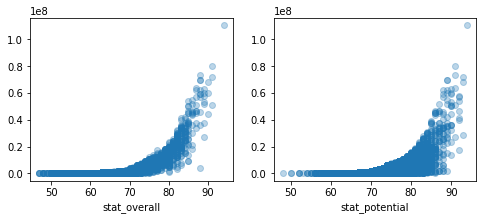

In [69]:
plot_data = fifa_train[['value','stat_overall','stat_potential']].copy() 
fig = plt.figure(figsize=(8,3)) 
for count,col in enumerate(['stat_overall','stat_potential']):
    ax = fig.add_subplot(1,2,count+1) 
    x = plot_data[col]
    y = plot_data['value']
    ax.scatter(x,y,alpha=0.3)
    ax.set_xlabel(col)

당연한 이야기지만 역량이 높을수록 몸값이 높게 평가되는 모습도 확인할 해볼 수가 있었다. 그리고 잠재 역량 보다는 실제로 역량을 발휘하는 것이 몸값 인상에 더 효과적인 것 같다. 

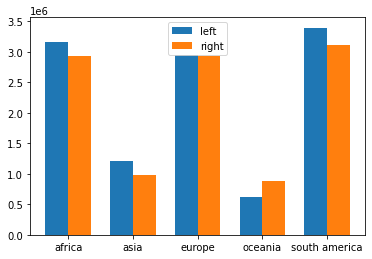

In [70]:
plot_data = fifa_train.groupby(['continent','prefer_foot']).agg({'value':np.mean}).pivot_table(index='continent',columns='prefer_foot')['value']
fig = plt.figure() 
ax = fig.add_subplot() 
x = np.arange(len(plot_data.index))
x_lbl = plot_data.index
y1 = plot_data['left']
y2 = plot_data['right']
width = 0.35
ax.bar(x-width/2,y1,width=width,label='left')
ax.bar(x+width/2,y2,width=width,label='right')
ax.set_xticks(x)
ax.set_xticklabels(x_lbl)
ax.legend()

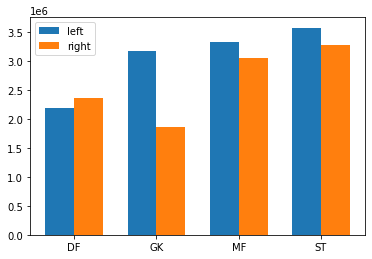

In [71]:
plot_data = fifa_train.groupby(['position','prefer_foot']).agg({'value':np.mean}).pivot_table(index='position',columns='prefer_foot')['value']
fig = plt.figure() 
ax = fig.add_subplot() 
x = np.arange(len(plot_data.index))
x_lbl = plot_data.index
y1 = plot_data['left']
y2 = plot_data['right']
width = 0.35 
ax.bar(x-width/2,y1,width=width,label='left')
ax.bar(x+width/2,y2,width=width,label='right')
ax.legend() 
ax.set_xticks(x)
ax.set_xticklabels(x_lbl)
plt.show()

추가로 각 대륙 + 사용하는 발 별 평균 몸값을 막대그래프로 그려보았다. 아시아 선수와 오세아니아 선수들의 몸값이 다른 대륙에 비해 낮은 감이 있지만 선호하는 발에 따라 몸값이 크게 차이나지는 않는 모양이다. 포지션별로 보면 오른 발을 사용하는 사람은 포지션에 따라 몸값이 상이하고 왼발을 사용하는 선수는 수비수, 골키퍼, 미드필더, 스트라이커 순으로 평균 연봉이 높아지고 있다. 골키퍼는 반대로 선호하는 발에 따라 평균 몸값의 차이가 좀 있었다.

 

어찌되었든 이 과정에서 대륙, 포지션, 사용하는 발도 변수들을 어떻게 조합하느냐에 따라 몸값이 변한다는 점을 알 수 있었다. 거의 모든 변수들이 무의미하지 않다는 것이다. 

이 변수들을 머신러닝 알고리즘에 적용하기 위한 데이터 스케일링을 진행했다. 

In [72]:
from pandas import Series, DataFrame


fifa_train['prefer_foot'] = fifa_train['prefer_foot'].map({'left':1,'right':0})
fifa_train['continent'] = fifa_train['continent'].map({'south america':1,'europe':2,'africa':3,'asia':4,'oceania':5})
fifa_train['position'] = fifa_train['position'].map({'ST':1,'GK':2,'DF':3,'MF':4})
fifa_train['contract_until'] = fifa_train['contract_until'].apply(lambda x : x-2018)


In [73]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler() 
scaler.fit(fifa_train[['age']])
age_scaled = scaler.transform(fifa_train[['age']])

scaler = MinMaxScaler() 
scaler.fit(fifa_train[['stat_overall','stat_potential']])
stat_scaled = scaler.transform(fifa_train[['stat_overall','stat_potential']])


In [76]:
fifa_train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,1,3,1,1,5,94,94,4,110500000
1,3,De Gea,27,2,2,2,0,4,91,93,1,72000000
2,7,L. Suárez,31,1,3,1,0,5,91,91,3,80000000
3,8,Sergio Ramos,32,2,2,3,0,4,91,91,3,51000000
4,9,J. Oblak,25,2,3,2,0,3,90,93,1,68000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,3,1,4,0,1,48,63,3,60000
8928,16936,C. Ehlich,19,2,2,3,0,1,47,59,2,40000
8929,16941,N. Fuentes,18,1,3,3,0,1,47,64,2,50000
8930,16942,J. Milli,18,2,3,2,0,1,47,65,1,50000


In [78]:
X = fifa_train.drop(columns=['id','name','value'])
y = fifa_train['value']

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor() 
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

이어서 test 데이터를 불러왔다.

In [87]:
fifa_test

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5,94,94,5
1,2,Neymar Jr,26,south america,2022,ST,right,5,92,93,5
2,4,K. De Bruyne,27,europe,2023,MF,right,4,91,92,4
3,5,E. Hazard,27,europe,2020,ST,right,4,91,91,4
4,6,L. Modrić,32,europe,2020,MF,right,4,91,91,4
...,...,...,...,...,...,...,...,...,...,...,...
3823,16924,R. Takae,20,asia,2021,MF,right,1,48,63,2
3824,16929,L. Wahlstedt,18,europe,2018,GK,right,1,48,65,1
3825,16932,Y. Góez,18,south america,2021,MF,right,1,48,65,2
3826,16937,A. Kaltner,18,europe,2020,ST,right,1,47,61,2


test 데이터도 train 데이터와 동일한 방법으로 정제와 스케일링을 진행한다. 

In [97]:
fifa_test['prefer_foot'] = fifa_test['prefer_foot'].map({'left':1,'right':0})
fifa_test['continent'] = fifa_test['continent'].map({'south america':1,'europe':2,'africa':3,'asia':4,'oceania':5})
fifa_test['position'] = fifa_test['position'].map({'ST':1,'GK':2,'DF':3,'MF':4})
fifa_test['contract_until'] = fifa_test['contract_until'].apply(lambda x : x-2018)


In [98]:
scaler = MinMaxScaler() 
scaler.fit(fifa_test[['age']])
age_scaled = scaler.transform(fifa_test[['age']])

scaler = MinMaxScaler() 
scaler.fit(fifa_test[['stat_overall','stat_potential']])
stat_scaled = scaler.transform(fifa_test[['stat_overall','stat_potential']])

In [99]:
fifa_test

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,2,4,1,0,5,94,94,5
1,2,Neymar Jr,26,1,4,1,0,5,92,93,5
2,4,K. De Bruyne,27,2,5,4,0,4,91,92,4
3,5,E. Hazard,27,2,2,1,0,4,91,91,4
4,6,L. Modrić,32,2,2,4,0,4,91,91,4
...,...,...,...,...,...,...,...,...,...,...,...
3823,16924,R. Takae,20,4,3,4,0,1,48,63,2
3824,16929,L. Wahlstedt,18,2,0,2,0,1,48,65,1
3825,16932,Y. Góez,18,1,3,4,0,1,48,65,2
3826,16937,A. Kaltner,18,2,2,1,0,1,47,61,2


In [100]:
x = fifa_test.drop(columns=['id','name'])
y_hat = rf.predict(x)

fifa_test['value'] = y_hat

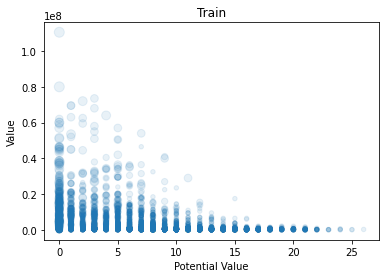

In [104]:
fig = plt.figure() 
ax = fig.add_subplot() 
# for x1,y1 in zip(x,y):
ax.scatter(x,y,color='tab:blue',alpha=0.1,sizes=size)
ax.set_title('Train')
ax.set_xlabel('Potential Value')
ax.set_ylabel('Value')
plt.show()

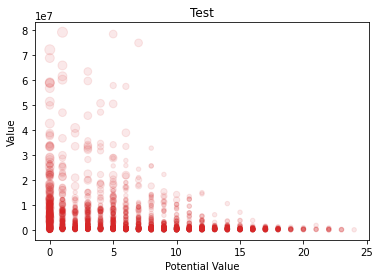

In [105]:
# 잠재 역량에서 기존 역량을 빼 잠재 가치를 산출 
x_test = fifa_test['stat_potential']-fifa_test['stat_overall']
y_hat = fifa_test['value']
# 인지도에 따라 점의 사이즈를 차등화 
size = fifa_test['reputation']*20

fig = plt.figure() 
ax = fig.add_subplot() 
# for x1,y1 in zip(x,y):
ax.scatter(x_test,y_hat,color='tab:red',alpha=0.1,sizes=size)
ax.set_title('Test')
ax.set_xlabel('Potential Value')
ax.set_ylabel('Value')
plt.show()

위 그래프는 맨 처음 train set으로 그린 것이었고, 아래 그래프는 예측한 값으로 그린 것이다. 얼추 비슷하게 나온다. 각 대륙별, 선호하는 발별, 포지션별 그래프를 그려서 비교해보아도 비슷하게 그래프가 그려진다. 

이제 submission 데이터 파일을 불러와 예측한 이적료 정보를 담는다.

In [106]:
submission = pd.read_csv(io.StringIO(uploaded['submission2.csv'].decode('utf-8')))
submission['value'] = y_hat

In [109]:
submission

,id,value
0,1,72280000.0
1,2,79300000.0
2,4,65995000.0
3,5,68955000.0
4,6,58870000.0
...,...,...
3823,16924,59000.0
3824,16929,50800.0
3825,16932,60100.0
3826,16937,42500.0
